https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install translate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:


!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [4]:
import pandas as pd


In [5]:
df = pd.read_csv('/content/train.csv')
df.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


**target의 값 시각화**

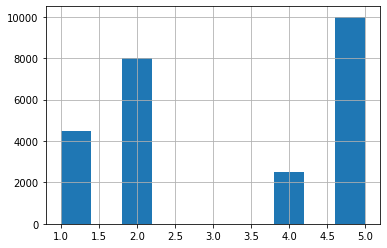

In [6]:
df['target'].hist()

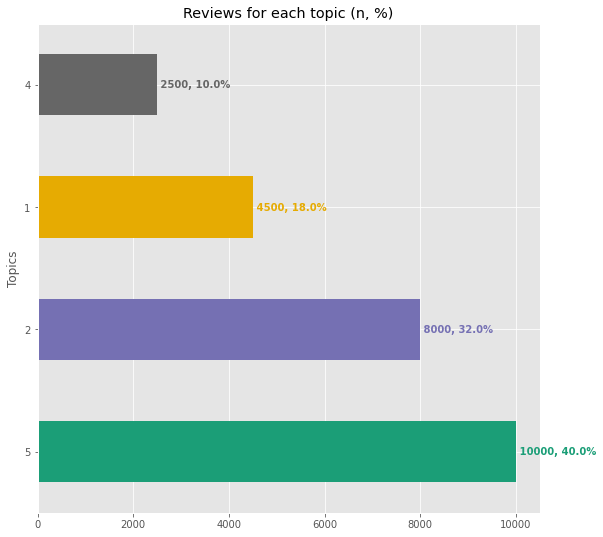

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["target"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['target'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['target'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

**조건에 맞게 translate**

In [8]:
from translate import Translator
from termcolor import colored


translator= Translator(from_lang="kr", to_lang="kr")

def print_rand_example(df, col_name, col_value, chars=180):
  '''print a random review and its translation given a label
  Args:
    - df: input dataframe
    - col_name: column to use as filter (e.g. Label)
    - col_value: value of col_name to use as filter 

    - chars (optional, def:180) max number of characters to display
  '''
  original = df[df[col_name]==col_value].sample()["reviews"].values[0]
  translation = translator.translate(original).replace("&#39;","'")
  print(colored("\nOriginal", 'green', attrs=['bold','underline']))
  print(original[0:chars] + "...")
  print(colored("\nTranslation", 'red', attrs=['bold','underline']))
  print(translation[0:chars] + "...")

In [9]:
print_rand_example(df, "target", 1)


Original
끝물이라고는 하지만 1개 서비스로 더 왔고 그거 제외하고 8개가 완전 마르고 알도없어서 버렸어요 엄마집까지 6박스시켯는데.. 다음엔 안시킬것같아요...

Translation
끝물이라고는 하지만 1개 서비스로 더 왔고 그거 제외하고 8개가 완전 마르고 알도없어서 버렸어요 엄마집까지 6박스시켯는데.. 다음엔 안시킬것같아요...


**split in train and test set**

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

#y = tf.keras.utils.to_categorical(df["target"].values, num_classes=6)

x_train, x_test, y_train, y_test = train_test_split(df['reviews'], df['target'], test_size=0.25)

## Data modeling

**Load BERT with TensorFlow Hub**



In [12]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Questa collezione di Haiku è una porta aperta sulla cultura giapponese."]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 1.08269431e-01, -9.16300118e-02, -3.19652706e-01,
        -1.70694496e-02,  3.34133953e-01,  2.00266495e-01,
        -2.46935934e-01, -5.43310583e-01, -3.56957525e-01,
        -2.97796339e-01, -2.08980575e-01,  1.42025962e-01,
         2.72504054e-02, -4.33980882e-01, -5.73599875e-01,
        -8.82729352e-01,  2.37144008e-01, -1.87127769e-01,
        -2.56523997e-01, -2.46629968e-01,  6.32454157e-01,
         1.21353932e-01, -3.95606428e-01,  1.58425495e-01,
        -6.60165250e-02, -1.00859702e+00,  3.03425044e-01,
         2.40533538e-02, -9.84719545e-02, -6.36505902e-01,
         1.15401857e-01, -7.62528837e-01, -5.43886423e-01,
        -4.67392147e-01, -6.24042749e-01,  2.63593107e-01,
        -4.41221416e-01,  6.62038177e-02, -3.88788283e-01,
         1.61619782e-02,  1.15522929e-01, -4.35087234e-01,
        -5.12637258e-01,  2.74717331e-01, -3.44000757e-01,
        -1.88089788e-01,  1.52753713e-02, -3.23565960e-01,
      

**observe semantic textual similarities**

In [13]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

**Create and train the classification model**

In [14]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

In [15]:
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

*model*

In [16]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='reviews')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(1, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [22]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
586/586 [==============================] - 308s 496ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - balanced_recall: 1.0000 - balanced_precision: 1.0000 - balanced_f1_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_balanced_recall: 1.0000 - val_balanced_precision: 1.0000 - val_balanced_f1_score: 1.0000
Epoch 2/20
586/586 [==============================] - 268s 458ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - balanced_recall: 1.0000 - balanced_precision: 1.0000 - balanced_f1_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_balanced_recall: 1.0000 - val_balanced_precision: 1.0000 - val_balanced_f1_score: 1.0000
Epoch 3/20
586/586 [==============================] - 269s 459ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - balanced_recall: 1.0000 - balanced_precision: 1.0000 - balanced_f1_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_balanced_recall: 1.0000 - val_balanced_precision: 1.0000 - val_balanced_f1_score: 1.0000
Epoc

**결과  plot**

In [ ]:

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

**Predict**

In [25]:
# test prediction on some newly generated reviews
reviews = ["이 제품은 가성비가 좋다"
]

# observe translated samples
print([translator.translate(review).replace("&#39;","'") for review in reviews])

['이 제품은 가성비가 좋다']


In [26]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(reviews)

1/1 [==============================] - 1s 1s/step


[0]

**test**

In [29]:
# load blind set
test_set = pd.read_csv('/content/test.csv')
test_set.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


In [30]:
from sklearn.metrics import classification_report


y_pred = predict_class(test_set["reviews"])
#print(classification_report(test_set["Labels"], y_pred))

782/782 [==============================] - 269s 342ms/step


In [ ]:
from tensorflow import keras
[np.argmax(pred) for pred in y_pred]


In [38]:
submission = pd.read_csv("./sample_submission.csv") 

submission.head() 

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [39]:
# 예측 값 넣어주기
submission["target"] = y_pred 

# 데이터가 잘 들어갔는지 확인합니다.
submission.head() 

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [40]:
# submission을 csv 파일로 저장합니다.
# index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다. 
# 정확한 채점을 위해 꼭 index=False를 넣어주세요.
submission.to_csv("submission.csv",index=False)